# Factor Analysis
***
October 10, 2022

In [1]:
import warnings
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import scipy as sp
import statsmodels as sm
import scipy.stats as spstat
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
plt.style.use("ggplot")

## Read-In Data
__[Fama-French](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)__ Research Data as of October 10, 2022


In [2]:
# Load and clean Fama-French Data

# 3 Factor
# data = pd.read_csv("../Data/F-F_Research_Data_Factors.CSV", skiprows=2).iloc[:-98, :]
# ff3_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
# data = pd.read_csv(ff3_url, skiprows=2).iloc[:-98, :]

# 5 Factor
# data = pd.read_csv("../Data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=2).iloc[:-60, :]
ff5_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
data = pd.read_csv(ff5_url, skiprows=2).iloc[:-60, :]

data.columns = ["Date", "Mkt_RF", "SMB", "HML", "RMW", "CMA", "RF"]
data["Date"] = pd.to_datetime(data["Date"], format="%Y%m")
data.set_index("Date", inplace=True)
data = data.astype(float)
data /= 100

# Add momentum
mom = pd.read_csv("http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip", skiprows=12).iloc[:-99, :]
mom.columns = ["Date", "MOM"]
mom["Date"] = pd.to_datetime(mom["Date"], format="%Y%m")
mom.set_index("Date", inplace=True)
mom = mom.astype(float)
mom /= 100

# Merge
data = pd.merge(data, mom, left_index=True, right_index=True)
data = data[["Mkt_RF", "SMB", "HML", "RMW", "CMA", "MOM", "RF"]]

# Select since date
# since_y = "1963"
# Or all data
since_y = str(data.index.min().year)
data = data[since_y:]
data.head()

,Mkt_RF,SMB,HML,RMW,CMA,MOM,RF
Date,,,,,,,
1963-07-01,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0090,0.0027
1963-08-01,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0101,0.0025
1963-09-01,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0019,0.0027
1963-10-01,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0312,0.0029
1963-11-01,-0.0085,-0.0088,0.0175,-0.0051,0.0224,-0.0074,0.0027


## Returns By Factor 
Recreation of Table 1: Returns by Factor for Year With Monthly Rebalance

In [3]:
tmp = data.copy()
tmp = np.exp(tmp.loc["2008":"2021"].drop("RF", axis=1).apply(lambda x: np.log1p(x)).resample("Y").sum()) - 1
tmp.index = tmp.index.year
tmp = tmp.T
tmp *= 100
tmp.loc["Dispersion",:] = tmp.drop("Mkt_RF").max() - tmp.drop("Mkt_RF").min()
tmp = tmp.round(2)
table1 = tmp.style.highlight_max(subset=(["SMB", "HML", "RMW", "CMA", "MOM"], slice(None)), color='green').highlight_min(subset=(["SMB", "HML", "RMW", "CMA", "MOM"], slice(None)), color='red').format("{:.2f}")
print("Returns by Factor for Year with Monthly Rebalancing")
display(table1)
print(f"Average Dispersion: {tmp.iloc[-1,:].mean():.2f}%")

Returns by Factor for Year with Monthly Rebalancing


Date,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Mkt_RF,-37.78,28.23,17.35,0.44,16.25,35.18,11.71,0.07,13.25,21.36,-6.85,27.71,23.50,23.55
SMB,5.57,7.49,12.92,-4.53,-0.32,6.39,-6.94,-5.97,8.83,-5.11,-5.03,-4.32,5.46,-1.61
HML,2.04,-4.62,-3.85,-8.20,8.71,2.13,-1.73,-9.95,20.58,-10.84,-10.62,-8.09,-30.34,22.22
RMW,23.98,1.79,-1.60,14.03,-5.03,-3.39,0.74,0.58,3.19,3.98,-2.11,3.44,-2.27,24.60
CMA,5.63,-1.57,9.00,-1.17,7.93,0.75,-1.47,-8.85,8.70,-9.32,-0.33,-2.99,-8.70,10.44
MOM,18.71,-52.68,6.39,8.09,-1.15,5.54,0.93,21.41,-18.20,3.60,11.20,-5.76,-0.34,-2.84
Dispersion,21.94,60.17,16.77,22.22,13.74,9.77,7.87,31.36,38.78,14.83,21.82,11.53,35.81,27.44


Average Dispersion: 23.86%


In [5]:
w, h = 600, 600

px.imshow(tmp.T.drop("Dispersion", axis=1).corr().round(2), title="Factor Correlation", text_auto=True, color_continuous_scale="Picnic", aspect="auto", width=w, height=h)

## Cumulative Performance

### Calculate Cumulative Returns

In [3]:
# Cumulative returns of factors
cum_data = (1 + data).cumprod() - 1
cum_data.head()

,Mkt_RF,SMB,HML,RMW,CMA,MOM,RF
Date,,,,,,,
1963-07-01,-0.003900,-0.004100,-0.009700,0.006800,-0.011800,0.009000,0.002700
1963-08-01,0.046602,-0.012067,0.008125,0.010424,-0.015259,0.019191,0.005207
1963-09-01,0.030171,-0.017204,0.009436,0.003250,-0.012403,0.021127,0.007921
1963-10-01,0.056234,-0.030865,0.008427,0.031341,-0.032254,0.052987,0.010844
1963-11-01,0.047256,-0.039394,0.026074,0.026082,-0.010576,0.045194,0.013573


### Plot Performance
This uses `since_y` referenced in [Read-In Data](##Read-In-Data).

In [134]:
# Plot Factors
# plt.figure(figsize=(16, 10))
# ax = cum_data.plot(figsize=(12, 8))
# plt.title(f"Factor Cumulative Returns Since {since_y}", fontsize=20)
# plt.legend()
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     ax.set_yticklabels([f"{x:.0%}" for x in ax.get_yticks()])
# plt.show()

px.line(cum_data, title=f"Factor Cumulative Returns Since {since_y}")

## Analysis of Returns

### Distributions of Factor Returns

In [131]:
# Histogram of Each Factor Returns
# data.hist(figsize=(15, 10), bins=50)
# plt.suptitle(f"Distributions of Returns Since {since_y}", fontsize=20)
# plt.show()

px.histogram(data, title=f"Distributions of Returns Since {since_y}", marginal="rug")

In [132]:
# Histogram of Each Factor Log Returns
# np.log1p(data).hist(figsize=(15, 10), bins=50)
# plt.suptitle(f"Distributions of Log-Returns Since {since_y}", fontsize=20)
# plt.show()

px.histogram(np.log1p(data), title=f"Distributions of Log-Returns Since {since_y}", marginal="rug")

### Descriptive Stats and More

In [7]:
# In-Depth Descriptions
stats = data.describe()
stats.loc['var'] = data.var().tolist()
stats.loc['skew'] = data.skew().tolist()
stats.loc['kurt'] = data.kurtosis().tolist()
stats

,Mkt_RF,SMB,HML,RMW,CMA,MOM,RF
count,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000
mean,0.005573,0.002271,0.002981,0.002724,0.002843,0.006294,0.003626
std,0.044772,0.030246,0.029660,0.022154,0.020400,0.041906,0.002682
min,-0.232400,-0.153500,-0.139700,-0.187300,-0.069400,-0.343000,0.000000
25%,-0.019675,-0.015175,-0.013875,-0.007875,-0.010000,-0.009525,0.001400
50%,0.009150,0.001000,0.002450,0.002400,0.000950,0.007350,0.003800
75%,0.034000,0.020350,0.017500,0.013075,0.014900,0.028975,0.005100
max,0.161000,0.183400,0.127500,0.130900,0.090500,0.182000,0.013500
var,0.002005,0.000915,0.000880,0.000491,0.000416,0.001756,0.000007
skew,-0.503299,0.342255,0.106890,-0.299731,0.302173,-1.283580,0.659697


### Pandas-Profiling
__[Pandas-Profiling Package](https://pandas-profiling.ydata.ai/docs/master/index.html)__ can help us create more robust exploratory data analyses.

In [8]:
# Pandas Profiling Report
profile = ProfileReport(data, title="Fama-French 5 Factor Profiling Report")

# As HTML
profile.to_file("../Outputs/factor_report.html")

# As Widget (not working rn)
# profile.to_widgets()

# Display
# display(profile)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Adding Peformance by Date

#### How to get row and columns of best/worst:

In [9]:
# Best Date for Each Factor
data.idxmax()

Mkt_RF   1974-10-01
SMB      2000-02-01
HML      2022-01-01
RMW      2000-11-01
CMA      2001-02-01
MOM      2000-02-01
RF       1981-06-01
dtype: datetime64[ns]

In [10]:
# Best Factor by Date
data.idxmax(axis=1)

Date
1963-07-01       MOM
1963-08-01    Mkt_RF
1963-09-01       CMA
1963-10-01       MOM
1963-11-01       CMA
               ...  
2022-04-01       HML
2022-05-01       HML
2022-06-01       RMW
2022-07-01    Mkt_RF
2022-08-01       MOM
Length: 710, dtype: object

### Adding Best and Worst Performing Factor

In [11]:
# Create a New DataFrame
data_best = data.copy()
# Best Performance by date
data_best["Best"] = data.idxmax(axis=1)
data_best["Worst"] = data.idxmin(axis=1)

# Pandas Profiling Report
profile = ProfileReport(data_best, title="Fama-French 5 Factor Returns Report", explorative=True)
# As HTML
profile.to_file("../Outputs/f_f_five_factor_report.html")

# display(profile)
data_best

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

,Mkt_RF,SMB,HML,RMW,CMA,MOM,RF,Best,Worst
Date,,,,,,,,,
1963-07-01,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0090,0.0027,MOM,CMA
1963-08-01,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0101,0.0025,Mkt_RF,SMB
1963-09-01,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0019,0.0027,CMA,Mkt_RF
1963-10-01,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0312,0.0029,MOM,CMA
1963-11-01,-0.0085,-0.0088,0.0175,-0.0051,0.0224,-0.0074,0.0027,CMA,SMB
...,...,...,...,...,...,...,...,...,...
2022-04-01,-0.0946,-0.0040,0.0619,0.0363,0.0592,0.0489,0.0001,HML,Mkt_RF
2022-05-01,-0.0034,-0.0006,0.0841,0.0144,0.0398,0.0248,0.0003,HML,Mkt_RF
2022-06-01,-0.0843,0.0130,-0.0597,0.0185,-0.0470,0.0079,0.0006,RMW,Mkt_RF


### Using Log-Returns

__[Why Use Logarithmic Returns In Time Series Modelling?](https://lucaslouca.com/Why-Use-Logarithmic-Returns-In-Time-Series-Modelling/)__

In [12]:
# Log Data
data_log = data.copy()
data_log = data_log.apply(lambda x: np.log1p(x))
data_log_best = data_log.copy()
# Add best column
data_log_best["Best"] = data_log.idxmax(axis=1)
# Adding worst column
data_log_best["Worst"] = data_log.idxmin(axis=1)

# Pandas Profiling Report
# profile = ProfileReport(data_log_best, title="Fama-French 5 Factor Log Returns Report", html={"style": {"full_width": True}}, sort=None)
# As HTML
# profile.to_file("../Outputs/f_f_five_factor_log_report.html")

# display(profile)
data_log_best

,Mkt_RF,SMB,HML,RMW,CMA,MOM,RF,Best,Worst
Date,,,,,,,,,
1963-07-01,-0.003908,-0.004108,-0.009747,0.006777,-0.011870,0.008960,0.002696,MOM,CMA
1963-08-01,0.049457,-0.008032,0.017840,0.003594,-0.003506,0.010049,0.002497,Mkt_RF,SMB
1963-09-01,-0.015825,-0.005214,0.001299,-0.007125,0.002896,0.001898,0.002696,CMA,Mkt_RF
1963-10-01,0.024985,-0.013998,-0.001001,0.027615,-0.020305,0.030723,0.002896,MOM,CMA
1963-11-01,-0.008536,-0.008839,0.017349,-0.005113,0.022153,-0.007428,0.002696,CMA,SMB
...,...,...,...,...,...,...,...,...,...
2022-04-01,-0.099378,-0.004008,0.060060,0.035657,0.057514,0.047742,0.000100,HML,Mkt_RF
2022-05-01,-0.003406,-0.000600,0.080750,0.014297,0.039028,0.024497,0.000300,HML,Mkt_RF
2022-06-01,-0.088066,0.012916,-0.061556,0.018331,-0.048140,0.007869,0.000600,RMW,Mkt_RF


## Best and Worst

### Performance of Long Best Factor
Looking at the plot below, we can see its futile to quantify just holding the best factor. Obviously this is smart, if we knew what factor was going to peform the best each month we could hold that and have astronomical returns.

In [119]:
# Hold best strategy

# Dont even look at spread, way to good of returns
# data_best["Spread"] = data.max(axis=1) - data.min(axis=1)

# Temp var for returns from a year
yr_ = "2018"
tmp = data.copy()
tmp = tmp.loc[yr_:, :]

# Holding best
tmp["Hold Best"] = tmp.max(axis=1)

# plt.figure(figsize=(12, 8))
# plt.plot(((1 + tmp).cumprod() - 1), label=[i for i in tmp.columns.to_list()])
# plt.legend()
# plt.title(f"Holding Best Factor Peformance Since {yr_}", fontsize=20)
# plt.show()

fig = px.line(((1 + tmp).cumprod() - 1), title=f"Holding Best Factor Peformance Since {yr_}")
fig.show()

### Hold Last Months Best
What if we used last month as an indicator of what factor to hold this month?

In [136]:
# Creating hold of best factor from last month
# Copy DataFrame
tmp = data.copy().to_numpy()
# np array of maxes
maxes = pd.DataFrame(np.array([tmp.max(axis=1) for i in range(7)]).T, index=data_best.drop(["Best", "Worst"], axis=1).index, columns=data_best.drop(["Best", "Worst"], axis=1).columns)
# Mask
tmp = data.copy()
mask = (data == maxes).shift(-1).dropna()
# Filter
tmp["Hold Last Best"] = tmp[mask].sum(axis=1)


# This actually looks kinda good...
# yr_ = "2001"
# plt.figure(figsize=(12, 8))
# plt.plot(((1 + tmp.loc[yr_:, :]).cumprod() - 1), label=[i for i in tmp.columns.to_list()])
# plt.legend()
# plt.title(f"Holding Best Factor From Last Month Peformance Since {yr_}", fontsize=20)
# plt.show()

yr_ = "2018"
fig = px.line(((1 + tmp.loc[yr_:, :]).cumprod() - 1), title=f"Holding Best Factor From Last Month Peformance Since {yr_}")
fig.show()

# This actually looks kinda good...
# yr_ = "1963"
# plt.figure(figsize=(12, 8))
# plt.plot(((1 + tmp.loc[yr_:, :]).cumprod() - 1), label=[i for i in tmp.columns.to_list()])
# plt.legend()
# plt.title(f"Holding Best Factor From Last Month Peformance Since {yr_}", fontsize=20)
# plt.show()

yr_ = "1963"
fig = px.line(((1 + tmp.loc[yr_:, :]).cumprod() - 1), title=f"Holding Best Factor From Last Month Peformance Since {yr_}")
fig.show()

### Reversal: Hold Last Month's Worst
What if we played reversal and held the worst performing factor from last month, is there any benefit?

In [120]:
# Creating hold of best factor from last month
# Copy DataFrame
tmp = data.copy().to_numpy()
# np array of maxes
maxes = pd.DataFrame(np.array([tmp.min(axis=1) for i in range(7)]).T, index=data_best.drop(["Best", "Worst"], axis=1).index, columns=data_best.drop(["Best", "Worst"], axis=1).columns)
# Mask
tmp = data.copy()
mask = (data == maxes).shift(-1).dropna()
# Filter
tmp["Hold Last Best"] = tmp[mask].sum(axis=1)

# Doesn't look as good
# yr_ = "2010"
# plt.figure(figsize=(12, 8))
# plt.plot(((1 + tmp.loc[yr_:, :]).cumprod() - 1), label=[i for i in tmp.columns.to_list()])
# plt.legend()
# plt.title(f"Holding Worst Factor From Last Month Peformance Since {yr_}", fontsize=20)
# plt.show()

yr_ = "2010"
fig = px.line(((1 + tmp.loc[yr_:, :]).cumprod() - 1), title=f"Holding Worst Factor From Last Month Peformance Since {yr_}")
fig.show()

# Doesn't look as good
# yr_ = "1963"
# plt.figure(figsize=(12, 8))
# plt.plot(((1 + tmp.loc[yr_:, :]).cumprod() - 1), label=[i for i in tmp.columns.to_list()])
# plt.legend()
# plt.title(f"Holding Worst Factor From Last Month Peformance Since {yr_}", fontsize=20)
# plt.show()

yr_ = "1963"
fig = px.line(((1 + tmp.loc[yr_:, :]).cumprod() - 1), title=f"Holding Worst Factor From Last Month Peformance Since {yr_}")
fig.show()


### Plots

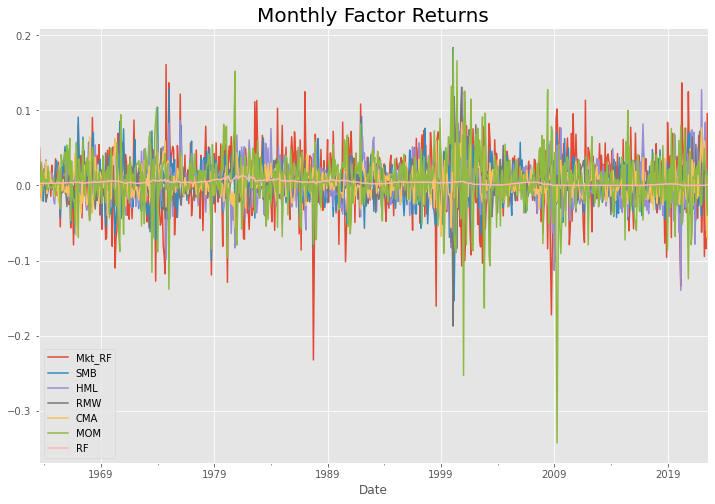

In [18]:
data_best.plot(figsize=(12, 8))
plt.title("Monthly Factor Returns", fontsize=20)
plt.show()

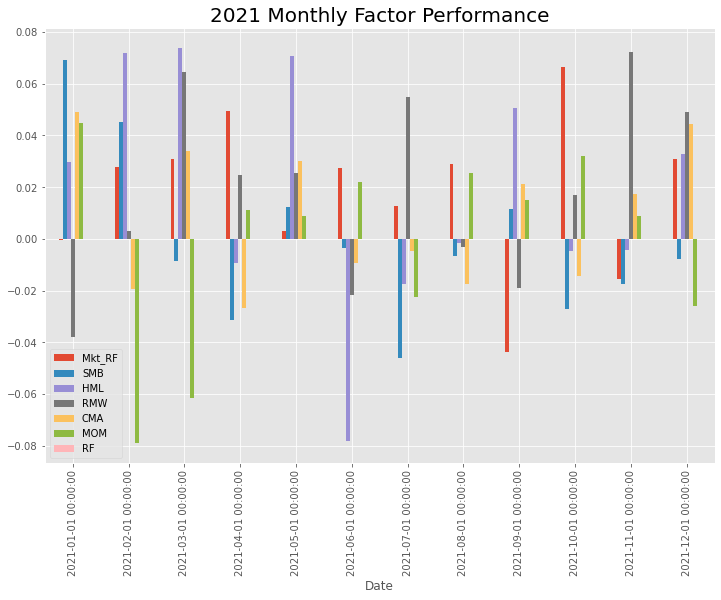

In [19]:
# Performance in 2021
yr_ = "2021"
data_best.loc[yr_].plot.bar(figsize=(12, 8))
plt.title(f"{yr_} Monthly Factor Performance", fontsize=20)
plt.show()

In [39]:
# Best and Worst Counts
# fig, ax = plt.subplots(figsize=(12,8))
# plt.bar(data_best["Best"].value_counts().index, data_best["Best"].value_counts(), label=r"$n$ times as Best Performer")
# plt.bar(data_best["Worst"].value_counts().index, data_best["Worst"].value_counts(), bottom=data_best["Best"].value_counts(), label=r"$n$ times as Worst Performer")
# plt.title("Best and Worst Counts", fontsize=20)
# plt.legend()
# ax.set_xlabel("Factor")
# ax.set_ylabel("Count")
# plt.show()

best_worst = pd.DataFrame(index=data_best["Best"].value_counts().index)
best_worst["Best"] = data_best["Best"].value_counts()
best_worst["Worst"] = data_best["Worst"].value_counts()
fig = px.bar(best_worst, title="Best-Worst Counts")
fig.show()

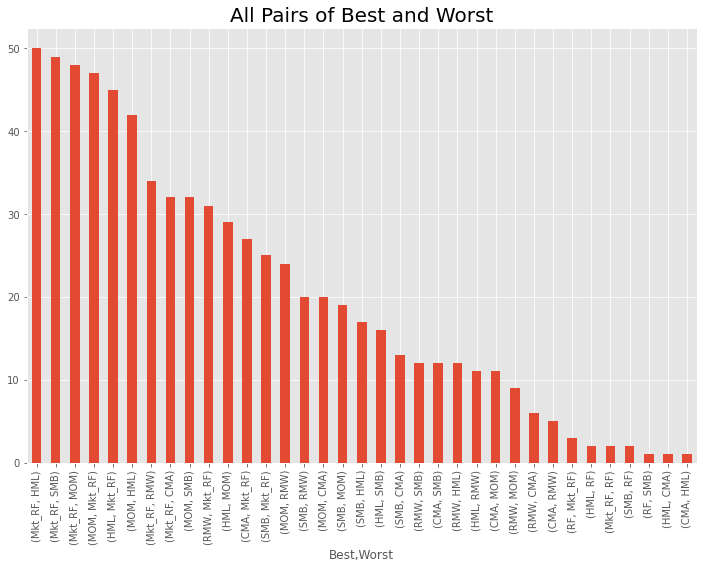

In [122]:
# All pairs of best and worst performance
data_best[["Best", "Worst"]].value_counts().plot(kind="bar", figsize=(12, 8))
plt.title("All Pairs of Best and Worst", fontsize=20)
plt.show()

# fig = px.bar(data_best[["Best", "Worst"]].value_counts())
# fig.show()

In [127]:
# tmp = data.copy()
# tmp = tmp.loc["2000":]
# ax = tmp.plot.bar(figsize=(25, 10), stacked=True)
# ticklabels = ['']*len(tmp.index)
# ticklabels[::12] = [item.strftime('%b %Y') for item in tmp.index[::12]]
# ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
# plt.gcf().autofmt_xdate()

# plt.show()

fig = px.bar(data, title="Factor Performance Over Time")
fig.show()

### Dickey-Fuller Test
Dickey Fuller test used to determine if data is non-stationary.

In [27]:
result = sm.tsa.stattools.adfuller(data.loc[:, "Mkt_RF"])

print(f"ADF Test Stat: {result[0]}")
print(f"p-Value: {result[1]}")
print(f"Number of Lags Used: {result[2]}")
print(f"Number of Observations: {result[3]}")
print("Critical Values:")
for k, v in result[4].items():
    print(f"\t{k} {v:.3f}")
print(f"Max Information Criterion: {result[5]:.3f}")

ADF Test Stat: -25.342609993529067
p-Value: 0.0
Number of Lags Used: 0
Number of Observations: 709
Critical Values:
	1% -3.440
	5% -2.866
	10% -2.569
Max Information Criterion: -2306.012


In [28]:
result = sm.tsa.stattools.adfuller(data_log.loc[:, "Mkt_RF"])

print(f"ADF Test Stat: {result[0]}")
print(f"p-Value: {result[1]}")
print(f"Number of Lags Used: {result[2]}")
print(f"Number of Observations: {result[3]}")
print("Critical Values:")
for k, v in result[4].items():
    print(f"\t{k} {v:.3f}")
print(f"Max Information Criterion: {result[5]:.3f}")

ADF Test Stat: -25.094861781136178
p-Value: 0.0
Number of Lags Used: 0
Number of Observations: 709
Critical Values:
	1% -3.440
	5% -2.866
	10% -2.569
Max Information Criterion: -2293.020


In [29]:
result = sm.tsa.stattools.adfuller(data.loc[:, "Mkt_RF"], maxlag=250, regression="ctt", autolag=None)

print(f"ADF Test Stat: {result[0]}")
print(f"p-Value: {result[1]}")
print(f"Number of Lags Used: {result[2]}")
print(f"Number of Observations: {result[3]}")
print("Critical Values:")
for k, v in result[4].items():
    print(f"\t{k} {v:.3f}")
# print(f"Max Information Criterion: {result[5]:.3f}")

ADF Test Stat: -0.6093402393325867
p-Value: 0.9957984290480147
Number of Lags Used: 250
Number of Observations: 459
Critical Values:
	1% -4.397
	5% -3.845
	10% -3.561


In [30]:
result = sm.tsa.stattools.adfuller(data_log.loc[:, "Mkt_RF"], maxlag=250, regression="ctt", autolag=None)

print(f"ADF Test Stat: {result[0]}")
print(f"p-Value: {result[1]}")
print(f"Number of Lags Used: {result[2]}")
print(f"Number of Observations: {result[3]}")
print("Critical Values:")
for k, v in result[4].items():
    print(f"\t{k} {v:.3f}")
# print(f"Max Information Criterion: {result[5]:.3f}")

ADF Test Stat: -0.682681869498292
p-Value: 0.9948450017728753
Number of Lags Used: 250
Number of Observations: 459
Critical Values:
	1% -4.397
	5% -3.845
	10% -3.561
